<p style="color:#FFF; background:#00008B; padding:12px; font-size:20px; font-style:italic;border-radius: 10px; text-align:center">
<span style="width:49%; display:inline-block; text-align:center">MABILEAU Juliette & BAJI Anas </span>
    <br>
<span style="font-size:48px; font-style:normal;text-align:center"><b>Homework</b></span><br>
<span style="width:49%; display:inline-block">M2 IREF, Economic Risks and Data Science </span></p>


## **Importation**

In [8]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn import ensemble
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

<h2 style="padding:16px; color:#FFF; background:#00008B; border-radius: 10px; text-align:center">Cross validation </h2>

## **Nettoyage des données**

On commence par visualiser les données

In [11]:
data = pd.read_csv("data_crossval.csv",header=None)
data.head()

,0,1,2
0,f,x,y
1,0.0477903522728,0,0.0113066151253013
2,0.0511994549171,0.01,0.0099999999999995
3,0.0547992916996,0.02,0.00723650824685293
4,0.0585963130405,0.03,5.5866943278228E-05


In [12]:
data.tail()

,0,1,2
196,0.933192798731,0.95,0.889002367088831
197,0.937403127209,0.96,0.872178069322666
198,0.94140368696,0.97,0.912544036827588
199,0.9452007083,0.98,0.920383807207712
200,0.948800545083,0.99,0.985800472016234


##### Ensuite, on nettoie les données et on vérifie qu'il n'y a pas de valeurs manquantes.

In [3]:
nombre_na_x= data[1].isna().sum()
nombre_na_y=data[2].isna().sum()
print(nombre_na_x)
print(nombre_na_y)

0
0


On remarque qu'il n'y a pas de valeurs manquantes dans nos colonnes. On va maintenant voir le type de données dans notre dataframe.

In [16]:
type_x = data[1].dtype
type_y = data[2].dtype

print(type_x)  
print(type_y)


object
object


Nos données sont de types "object", à la visualisation, nous avons remarqué que nos colonnes ne comportaient que des valeurs numériques. Nous allons donc transformer nos données en type "float64".

In [18]:

x_objet = data[1]
x = pd.to_numeric(x_objet, errors='coerce')
x_clean = x.dropna()
y_objet = data[2]
y = pd.to_numeric(y_objet, errors='coerce')
y_clean = y.dropna()
print(x_clean.dtype)
print(y_clean.dtype)

float64
float64


## **10-Fold Cross validation**

Après s'être assuré que nos données sont nettoyées et utilisables, nous les divisons en deux groupes : jeu d'entraînement et jeu de test. 80% des données seront affectées au jeu d'entraînement et 20% seront affectées au jeu de test.

In [19]:
x_train, x_val_test, y_train, y_val_test = train_test_split(x_clean, y_clean, test_size=0.2, random_state=1)
print("Taille du jeu d'entraînement :", x_train.shape, y_train.shape)
print("Taille du jeu de test :", x_val_test.shape, y_val_test.shape)

Taille du jeu d'entraînement : (160,) (160,)
Taille du jeu de test : (40,) (40,)


## **1. Régression polynomiale**

Afin de trouver le degré du modèle polynomial qui minimise l'erreur de validation croisée, nous allons créer une fonction qui nous permet de calculer la ***mean squared error*** (MSE) pour chaque modèle. La MSE représente la moyenne des carrés des écarts entre les prédictions et les valeurs réelles. L'erreur quadratique moyenne est une mesure standard de la qualité des prédictions, et plus elle est faible, meilleure est la performance du modèle.

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

In [20]:
def calculate_mse_for_degree(x_train, y_train, x_val, y_val, degree):
    
    # On commence par créer des features polynomiaux pour le degré donné
    poly = PolynomialFeatures(degree)
    x_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
    x_val_poly = poly.transform(x_val.reshape(-1, 1))

    # Ajuster un modèle linéaire sur les features polynomiaux
    model = LinearRegression()
    model.fit(x_train_poly, y_train)

    # Prédictions pour l'entraînement et validation
    y_train_pred = model.predict(x_train_poly)
    y_val_pred = model.predict(x_val_poly)

    # Calcul du MSE pour l'entraînement et validation
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    return train_mse, val_mse

On crée deux listes vides où on va stocker les erreurs MSE à différents degrés

In [23]:
train_errors_poly = []
valid_errors_poly= []

On crée une validation croisée à 10 plis les données d'entraînement seront divisées en 10 sous-ensembles. Les données seront mélangées avant d'être divisées en plis afin d'éviter les biais.

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [26]:
# Liste des degrés à tester
degrees = range(1, 11)

Afin d'évaluer quel modèle polynomial sur l'ensemble de modèles est le plus optimal, on utilise une boucle qui itère sur les plis de la validation croisée. Pour chaque pli, elle sépare les données d'entraînement et de validation. Ensuite, on calcule la MSE grâce à la fonction créée au-dessus pour chaque degré de polynôme et on stocke les résultats, d'abord pour chaque pli, puis dans une liste globale pour tous les plis et tous les degrés.

In [29]:
for train_index, val_index in kf.split(x_train):
    # Séparer les données en entraînement et validation pour ce pli
    x_train_fold, x_val_fold = x_train.values[train_index], x_train.values[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

    # Listes pour stocker les erreurs pour ce pli
    fold_train_errors = []
    fold_val_errors = []

    # Pour chaque degré de polynôme
    for degree in degrees:
        # Calculer le MSE pour ce degré
        train_mse, val_mse = calculate_mse_for_degree(x_train_fold, y_train_fold, x_val_fold, y_val_fold, degree)
        
        # Stocker les erreurs pour ce pli et ce degré
        fold_train_errors.append(train_mse)
        fold_val_errors.append(val_mse)

    # Ajouter les erreurs de ce pli à la liste globale
    train_errors_poly.append(fold_train_errors)
    valid_errors_poly.append(fold_val_errors)


On calcule la moyenne des erreurs de validation pour chaque degré de polynôme, sur l'ensemble des plis de validation croisée.

In [34]:
mean_valid_errors_poly = np.mean(valid_errors_poly, axis=0)
mean_train_errors_poly = np.mean(train_errors_poly, axis=0)

# Trouver le degré qui minimise l'erreur de validation
optimal_degree = degrees[np.argmin(mean_valid_errors_poly)]

print(f"Le degré optimal est : {optimal_degree}")

Le degré optimal est : 5


On utilise ce degré optimal pour transformer les données d'entraînement en ajoutant des caractéristiques polynomiales jusqu'au degré optimal et on entraîne ensuite un modèle de régression linéaire sur ces nouvelles caractéristiques

In [91]:
poly = PolynomialFeatures(optimal_degree)
x_train_poly = poly.fit_transform(x_train.values.reshape(-1, 1))

model_k_fold = LinearRegression()
model_k_fold.fit(x_train_poly, y_train)
#prédictions ensemble d'entraînement
y_pred_poly=model_k_fold.predict(x_train_poly)

On affiche graphiquement la régression polynomiale obtenue

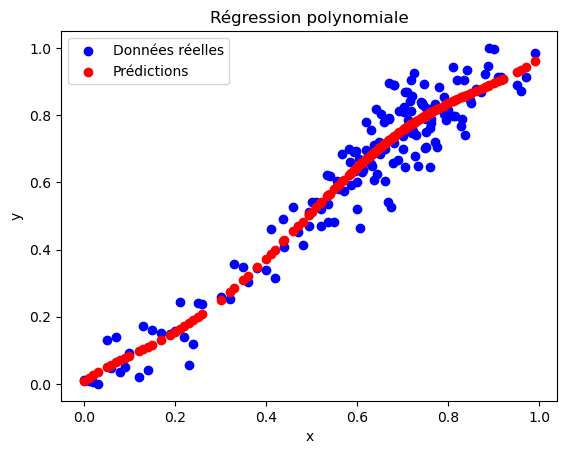

In [92]:
# Visualisation des données d'entraînement et des prédictions, graphique sur les données d'entraînement
plt.scatter(x_train,y_train, color='blue', label='Données réelles')
plt.scatter(x_train,y_pred_poly, color='red', label='Prédictions')
plt.title('Régression polynomiale')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## **2. Régression k-nn**

On crée deux listes vides où on va stocker les erreurs MSE à différents degrés

In [57]:
train_errors_knn = []
valid_errors_knn = []

Afin de trouver k, le nombre de voisins optimal du modèle de régression qui minimise l'erreur de validation croisée, nous allons créer une fonction qui nous permet de calculer la MSE pour chaque modèle. 

In [38]:
def calculate_mse_knn(x_train, y_train, x_val, y_val, n_neighbors):
    # Créer le modèle KNN
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Ajuster le modèle sur les données d'entraînement
    knn_model.fit(x_train.reshape(-1, 1), y_train)

    # Prédictions sur les données d'entraînement et de validation
    y_train_pred = knn_model.predict(x_train.reshape(-1, 1))
    y_val_pred = knn_model.predict(x_val.reshape(-1, 1))

    # Calculer le MSE pour l'entraînement et la validation
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    return train_mse, val_mse


On crée une validation croisée à 10 plis les données d'entraînement seront divisées en 10 sous-ensembles. Les données seront mélangées avant d'être divisées en plis afin d'éviter les biais.

In [34]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
n_neighbors_range = range(1, 21)  # De 1 à 20

Afin d'évaluer quel nombre de voisins est optimal, on utilise une boucle qui itère sur les plis de la validation croisée. Pour chaque pli, elle sépare les données d'entraînement et de validation. Ensuite, on calcule la MSE grâce à la fonction créée au-dessus pour chaque nombre de voisins et on stocke les résultats, d'abord pour chaque pli, puis dans une liste globale pour tous les plis et tous les k.

In [77]:
# Pour chaque pli de la validation croisée
for train_index, val_index in kf.split(x_train):
    # Séparer les données en entraînement et validation pour ce pli
    x_train_fold, x_val_fold = x_train.values[train_index], x_train.values[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

    # Variables pour stocker les erreurs pour ce pli
    fold_train_errors = []
    fold_val_errors = []

    # Pour chaque nombre de voisins
    for n_neighbors in n_neighbors_range:
        # Calculer le MSE pour ce nombre de voisins
        train_mse, val_mse = calculate_mse_knn(x_train_fold, y_train_fold, x_val_fold, y_val_fold, n_neighbors)
        
        # Stocker les erreurs pour ce pli et ce nombre de voisins
        fold_train_errors.append(train_mse)
        fold_val_errors.append(val_mse)

    # Ajouter les erreurs de ce pli à la liste globale
    train_errors_knn.append(fold_train_errors)
    valid_errors_knn.append(fold_val_errors)

On calcule la moyenne des erreurs de validation pour chaque degré de polynôme, sur l'ensemble des plis de validation croisée.

In [78]:
mean_valid_errors_knn = np.mean(valid_errors_knn, axis=0)
mean_train_errors_knn = np.mean(train_errors_knn, axis = 0)

# Trouver le nombre de voisins qui minimise l'erreur de validation
optimal_n_neighbors = n_neighbors_range[np.argmin(mean_valid_errors_knn)]
print(f"Le nombre optimal de voisins est : {optimal_n_neighbors}")

Le nombre optimal de voisins est : 10


On utilise ce degré optimal pour transformer les données d'entraînement en ajoutant des caractéristiques polynomiales jusqu'au degré optimal et on entraîne ensuite un modèle de régression linéaire sur ces nouvelles caractéristiques

In [89]:
# Créer le modèle KNN avec le nombre optimal de voisins
knn_model_final = KNeighborsRegressor(n_neighbors=optimal_n_neighbors)

# Ajuster le modèle sur l'ensemble d'entraînement complet
knn_model_final.fit(x_train.values.reshape(-1, 1), y_train)
#prédictions ensemble d'entraînement
y_pred_knn=knn_model_final.predict(x_train.values.reshape(-1, 1))

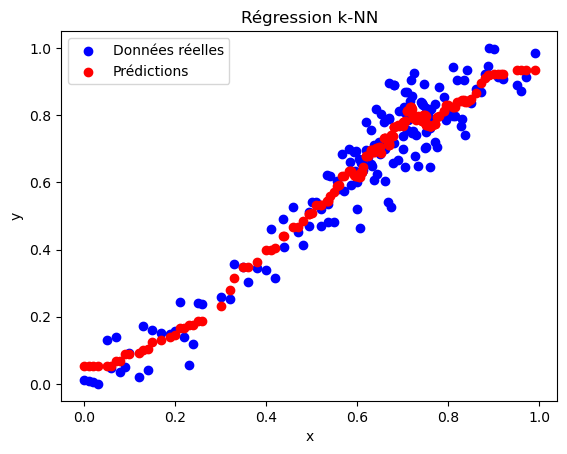

In [84]:
# Visualisation des données d'entraînement et des prédictions, graphique sur les données d'entraînement
plt.scatter(x_train,y_train, color='blue', label='Données réelles')
plt.scatter(x_train,y_pred_knn, color='red', label='Prédictions')
plt.title('Régression k-NN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## **3. Comparaison des résultats**

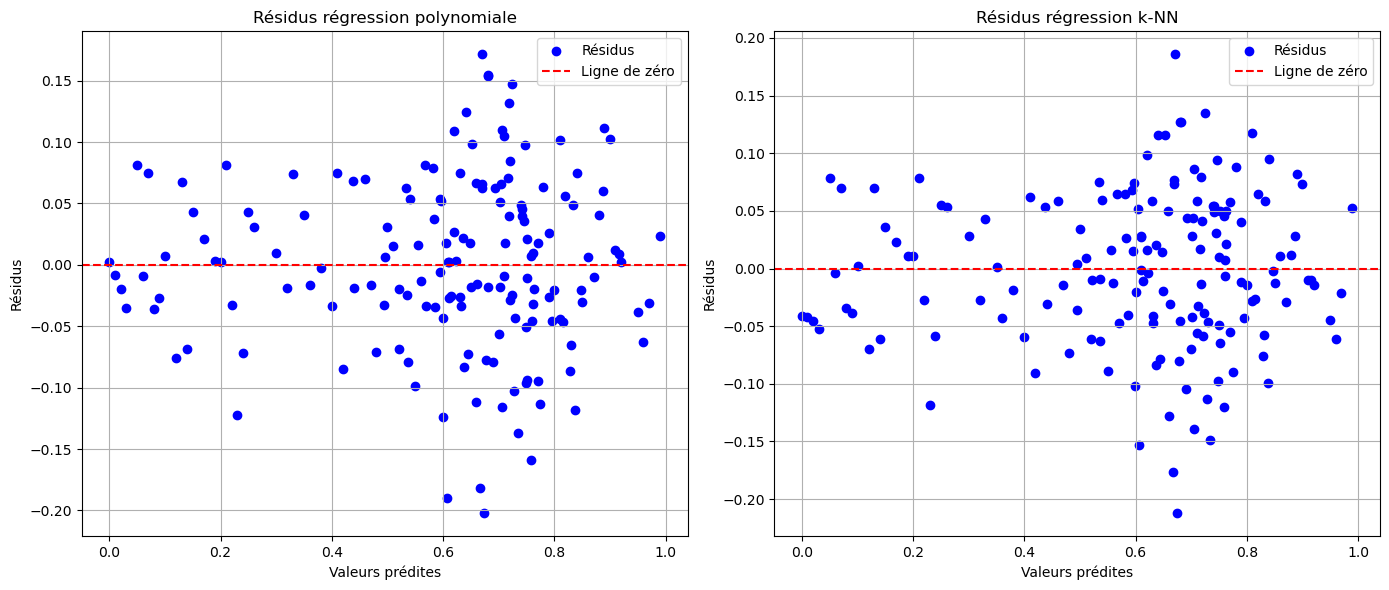

In [98]:
#Calcul des résidus
residus_poly = y_train - y_pred_poly
residus_knn=y_train - y_pred_knn

plt.figure(figsize=(14, 6))

# Sous-figure pour la régression polynomiale
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère sous-figure
plt.scatter(x_train, residus_poly, color='blue', marker='o', label='Résidus')
plt.axhline(y=0, color='red', linestyle='--', label='Ligne de zéro')
plt.title('Résidus régression polynomiale')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.legend()
plt.grid()

# Sous-figure pour la régression k-NN
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème sous-figure
plt.scatter(x_train, residus_knn, color='blue', marker='o', label='Résidus')
plt.axhline(y=0, color='red', linestyle='--', label='Ligne de zéro')
plt.title('Résidus régression k-NN')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.legend()
plt.grid()

# Ajustement de la mise en page
plt.tight_layout()
plt.show()

La distribution des résidus est aléatoire autour de 0 pour les deux graphiques. De plus, les résidus sont symétriques autour de la ligne de 0 pour les deux graphiques. Ainsi, la simple analyse du graphique des résidus ne peut permettre de différencier entre les deux modèles.

On trace les courbes des erreurs de validation et d'entraînement pour les deux modèles de régression : la régression polynomiale et la régression k-NN.

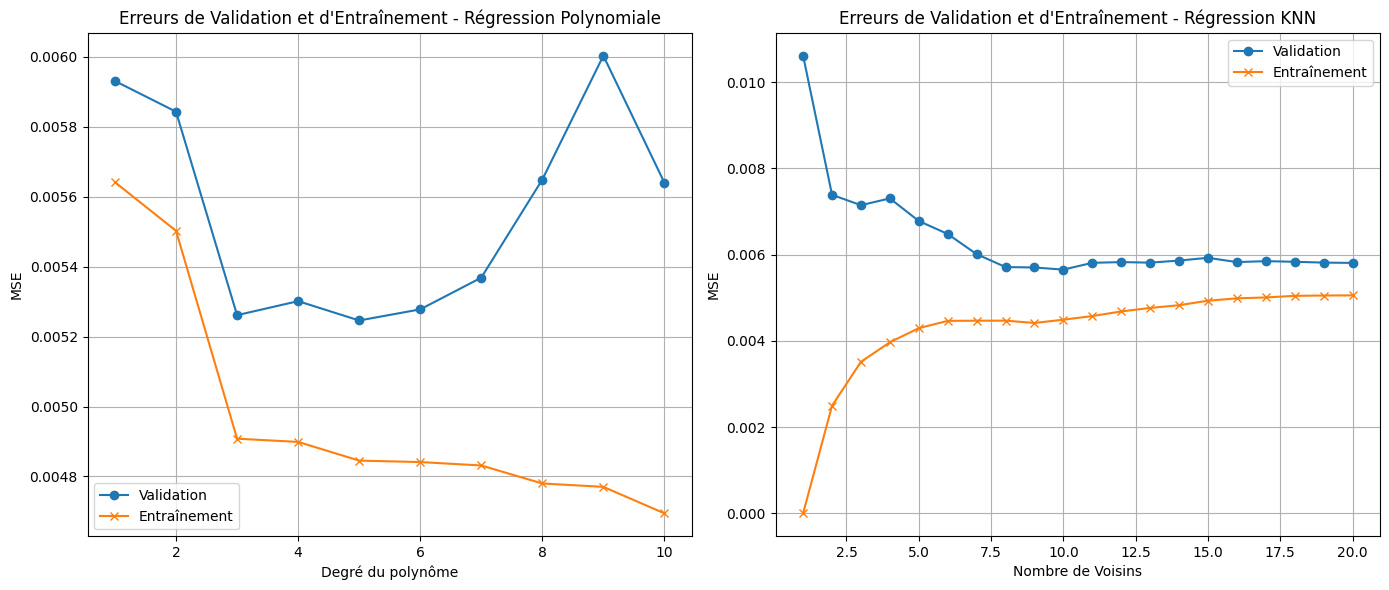

In [15]:
import matplotlib.pyplot as plt

# Degré du polynôme (1 à 10)
degrees = range(1, 11)
n_neighbors = range(1, 21)  # Pour KNN

# Tracer les erreurs de validation pour la régression polynomiale
plt.figure(figsize=(14, 6))

# Sous-figure pour la régression polynomiale
plt.subplot(1, 2, 1)
plt.plot(degrees, mean_valid_errors_poly, marker='o', label='Validation')
plt.plot(degrees, mean_train_errors_poly, marker='x', label='Entraînement')
plt.title('Erreurs de Validation et d\'Entraînement - Régression Polynomiale')
plt.xlabel('Degré du polynôme')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Sous-figure pour la régression KNN
plt.subplot(1, 2, 2)
plt.plot(n_neighbors, mean_valid_errors_knn, marker='o', label='Validation')
plt.plot(n_neighbors, mean_train_errors_knn, marker='x', label='Entraînement')
plt.title('Erreurs de Validation et d\'Entraînement - Régression KNN')
plt.xlabel('Nombre de Voisins')
plt.ylabel('MSE')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Le premier graphique montre comment l'erreur quadratique moyenne (MSE) varie en fonction du degré du polynôme du modèle adopté dans la régression polynomiale.

La courbe des erreurs d'entraînement (en jaune) montre les erreurs calculées sur les données d'entraînement. A mesure que le degré du polynôme augmente, l’erreur d'entraînement diminue. Cela est dû au fait qu’un polynôme de degré plus élevé peut mieux s’ajuster aux données d’entraînement en capturant plus de détails et de variations. 
La courbe des erreurs de validation montre les erreurs calculées sur les données de validation. A mesure que le degré augmente, l’erreur de validation diminue avec l'augmentation du degré du polynôme, car le modèle devient plus flexible et peut mieux s'ajuster aux données. Cependant, à partir du degré optimal calculé (d=5), l’erreur de validation commence à augmenter, indiquant que le modèle est trop ajusté (overfitting).

Le second graphique montre comment l'erreur quadratique moyenne (MSE) varie en fonction du nombre de voisins choisi dans le modèle de la régression k-NN.

Avec un nombre faible de voisins, l'erreur d'entraînement est faible mais l'erreur de validation est forte. Cela correspond à un fort risque d'overfitting. Avec un nombre trop élevé de voisins, les erreurs d'entraînement et de validation augmentent, cela correspond à une situation d'underfitting ; une situation où le modèle devient trop lisse et perd en précision. Le k optimal (k=10) est le minimum des erreurs de validation.

Les deux modèles polynomial et k-NN ont des MSE proches qu'on ne peut différencier graphiquement nous allons passer à une autre méthode afin de déterminer quel est le meilleur modèle.

##### Prédictions sur l'ensemble de test :

L'erreur quadratique moyenne sur l'ensemble de test est : 0.0034919405374289696


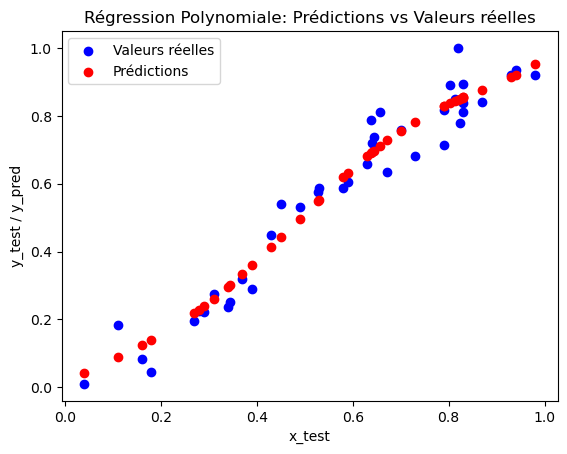

In [87]:
# Prédictions sur l'ensemble de test
x_val_poly = poly.transform(x_val_test.values.reshape(-1, 1))
y_pred_test_fold = model_k_fold.predict(x_val_poly)


# Calculer l'erreur quadratique moyenne (MSE)
mse_test = mean_squared_error(y_val_test, y_pred_test_fold)
print(f"L'erreur quadratique moyenne sur l'ensemble de test est : {mse_test}")

# Tracer les prédictions vs les vraies valeurs
plt.scatter(x_val_test, y_val_test, color='blue', label='Valeurs réelles')
plt.scatter(x_val_test, y_pred_test_fold, color='red', label='Prédictions')
plt.xlabel("x_test")
plt.ylabel("y_test / y_pred")
plt.legend()
plt.title("Régression Polynomiale: Prédictions vs Valeurs réelles")
plt.show()

L'erreur quadratique moyenne sur l'ensemble de test est : 0.0036805563872760114


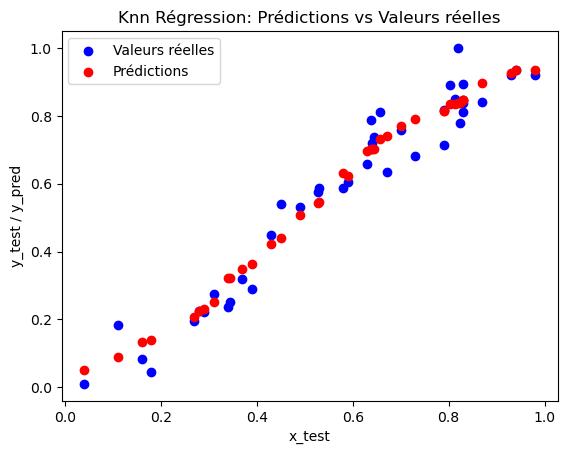

In [86]:
# Prédictions sur l'ensemble de test
y_pred_test_knn = knn_model_final.predict(x_val_test.values.reshape(-1, 1))


# Calculer l'erreur quadratique moyenne (MSE)
mse_test = mean_squared_error(y_val_test, y_pred_test_knn)
print(f"L'erreur quadratique moyenne sur l'ensemble de test est : {mse_test}")

# Tracer les prédictions vs les vraies valeurs
plt.scatter(x_val_test, y_val_test, color='blue', label='Valeurs réelles')
plt.scatter(x_val_test, y_pred_test_knn, color='red', label='Prédictions')
plt.xlabel("x_test")
plt.ylabel("y_test / y_pred")
plt.legend()
plt.title("Knn Régression: Prédictions vs Valeurs réelles")
plt.show()

Le MSE de la régression polynomiale est inférieur à celui de KNN, cela suggère que le modèle polynomial s'est mieux adapté à l'ensemble de test.

<h2 style="padding:16px; color:#FFF; background:#00008B; border-radius: 10px; text-align:center">Global minimum</h2>

On définit la fonction camelback à deux variables (x,y) qu'on cherche à minimiser

In [12]:
def function_camelback(x,y):
    return (4 - 2.1*x**2 + x**4/3)*x**2 + x*y +(-4+4*y**2)*y**2

On utilise cette fonction créée afin d'implémenter la fonction de fitness que nous allons utiliser dans notre algorithme génétique.

In [13]:
def eval_function(individual):
    # L'individu contient deux valeurs : x et y
    x, y = individual[0], individual[1]
    # Appel de la fonction camelback
    return (function_camelback(x, y),)  # DEAP attend un tuple en sortie

Les algorithmes génétiques sont des programmes d'optimisation stochastique basé sur les mécanismes de sélection naturelle et génétique.
- On commence avec un population de solutions possibles
- Leur "fitness" (performance relative) est évaluée
- Les solutions parmi cette population sont pris pour former une nouvelle population. A partir de leurs performances, on crée une population de nouvelles solutions grâce à 3 processus: selection, crossover et mutation.
- On continue le cycle jusqu'à trouver une solution

On met en place un algorithme génétique afin de trouver le minimum de la fonction camelback.

In [14]:
def geneticAlgorithm(n_population, n_generation, cxpb=0.8, mutpb=0.1):
    """
    Implémentation de l'algorithme génétique pour minimiser la fonction six-hump camelback.
    """
    # Définir les variables DEAP pour minimiser la fonction de fitness
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Créer un individu avec deux variables (x et y)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, -5, 5)  # Bornes de -5 à +5 pour x et y
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 2)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Enregistrer ta fonction d'évaluation
    toolbox.register("evaluate", eval_function)  # Utilise la fonction camelback
    toolbox.register("mate", tools.cxTwoPoint)  # Croisement
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)  # Mutation
    toolbox.register("select", tools.selTournament, tournsize=3)  # Sélection par tournoi

    # Initialisation des paramètres de l'algorithme
    pop = toolbox.population(n=n_population)
    hof = tools.HallOfFame(1)  # Meilleure solution trouvée
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Exécuter l'algorithme génétique avec les paramètres fournis
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=n_generation, stats=stats, halloffame=hof, verbose = False)

    # Retourner la meilleure solution et le journal d'évolution
    return hof, log

In [15]:
hof, log = geneticAlgorithm(n_population=1000, n_generation=40)
best_solution = hof[0]
print("Best solution:", best_solution)
print("Best fitness:", best_solution.fitness.values[0])

Best solution: [0.09225206723875945, -0.7141690164158294]
Best fitness: -1.0315906887848143


In [16]:
print(log)

gen	nevals	avg      	min      	max    
0  	1000  	926.784  	-0.952344	5977.66
1  	823   	219.109  	-0.965563	4032.31
2  	801   	26.6666  	-1.02287 	999.124
3  	816   	1.64069  	-1.02959 	152.244
4  	839   	0.0930617	-1.03135 	30.5617
5  	821   	-0.246886	-1.03137 	205.984
6  	822   	-0.692311	-1.03135 	31.2129
7  	803   	-0.463897	-1.03154 	179.873
8  	827   	-0.813346	-1.03157 	32.7075
9  	812   	-0.860482	-1.03159 	66.1977
10 	832   	-0.774232	-1.03154 	53.8504
11 	823   	-0.730833	-1.03157 	88.9487
12 	809   	-0.635079	-1.03157 	86.7374
13 	837   	-0.526765	-1.03157 	329.189
14 	801   	-0.745759	-1.03157 	123.359
15 	816   	-0.834111	-1.03157 	71.546 
16 	836   	0.0211508	-1.03154 	668.137
17 	823   	-0.982153	-1.03154 	8.76383
18 	794   	-0.958801	-1.03154 	21.289 
19 	844   	-0.164384	-1.03154 	255.001
20 	823   	0.994868 	-1.03154 	539.176
21 	818   	-0.880229	-1.03154 	38.3038
22 	821   	0.224369 	-1.03154 	556.482
23 	798   	-0.720168	-1.03154 	144.727
24 	822   	-0.953293	-1.0

Pour une population donnée de 1000, une probabilité de mutation de 0.1, on trouve une solution approchée à 0.01 de la solution exacte du problème de minimisation de la fonction camelback. On remarque que la meilleure fitness est la fitness qui se rapproche le plus du minimum.

Afin de mieux comprendre l'impact de l'évolution de la probabilité de mutation sur la convergence vers la solution optimale, nous allons créer une fonction qui détermine en fonction de la taille de la population et d'une probabilité sur un nombre de générations donnée, la meilleure valeur de fitness de 

In [19]:
def fit_pop_mut(population, mutation_probs):
    size_gen = 50

    plt.figure(figsize=(8, 5))

    for mut_prob in mutation_probs :
        result = []
        for gen in range(0,size_gen):
            hof, log = geneticAlgorithm(n_population  = population, n_generation=gen, cxpb=0.8,  mutpb=mut_prob)
            best_solution = hof[0]
            x,y = best_solution
            fitness_value = function_camelback(x,y)
            result.append((mut_prob, gen, best_solution, fitness_value))
            result_df= pd.DataFrame(result, columns=['Mutation_prob', 'Generations', 'Best Solution', 'Best Fitness'])
            df_subset = result_df[result_df["Mutation_prob"] == mut_prob]
        plt.plot(df_subset["Generations"], df_subset["Best Fitness"], label=f'mutation : {mut_prob}')
    plt.xlabel('Géneration')
    plt.ylabel('Meilleure valeur de fitness')
    plt.title('Influence de la probabilité de mutation sur la fitness pour une valeur de la population donnée')
    plt.legend()
    plt.grid(True)
    plt.show()

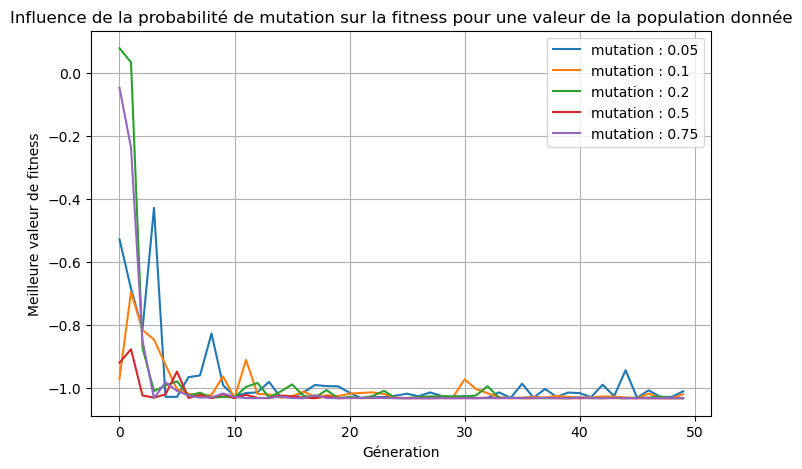

In [21]:
fit_pop_mut(100,mutation_probs=[0.05,0.1,0.2,0.5,0.75])

Les courbes montrent comment la fitness de la meilleure solution évolue avec les générations pour chaque probabilité de mutation pour une valeur de la population donnée.
La courbe bleue qui représente une probabilité de mutation de 0.05 converge lentement vers la valeur optimale de fitness. Tandis que les courbes rouges et violettes, qui représentent des probabilités de mutation respectivement de 0.5 et 0.75, sont celles qui convergent le plus rapidement vers la solution optimale.
Ainsi, on peut déduire qu'en général, une probabilité de mutation accrue permet une exploration plus efficace de l’espace de solutions conduisant une convergence plus rapide vers la solution optimale. En effet, ne probabilité de mutation accentuée fournit une diversité génétique plus élevée.

In [22]:
def fit_pop_size(mutation_prob, population_sizes):
    size_gen = 50
    plt.figure(figsize=(10, 6))

    for pop_size in population_sizes:
        results = []
        for gen in range(size_gen):
            hof, log = geneticAlgorithm(n_population=pop_size, n_generation=gen, cxpb=0.8, mutpb=mutation_prob)
            best_solution = hof[0]
            x, y = best_solution
            fitness_value = function_camelback(x, y)
            results.append((pop_size, gen, best_solution, fitness_value))

        # Create DataFrame after looping over all generations for each population size
        result_df = pd.DataFrame(results, columns=['Population Size', 'Generations', 'Best Solution', 'Best Fitness'])
        df_subset = result_df[result_df["Population Size"] == pop_size]

        plt.plot(df_subset["Generations"], df_subset["Best Fitness"], label=f'Population: {pop_size}')

    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Value')
    plt.title('Effect of Population Size on Fitness with a Fixed Mutation Probability')
    plt.legend()
    plt.grid(True)
    plt.show()


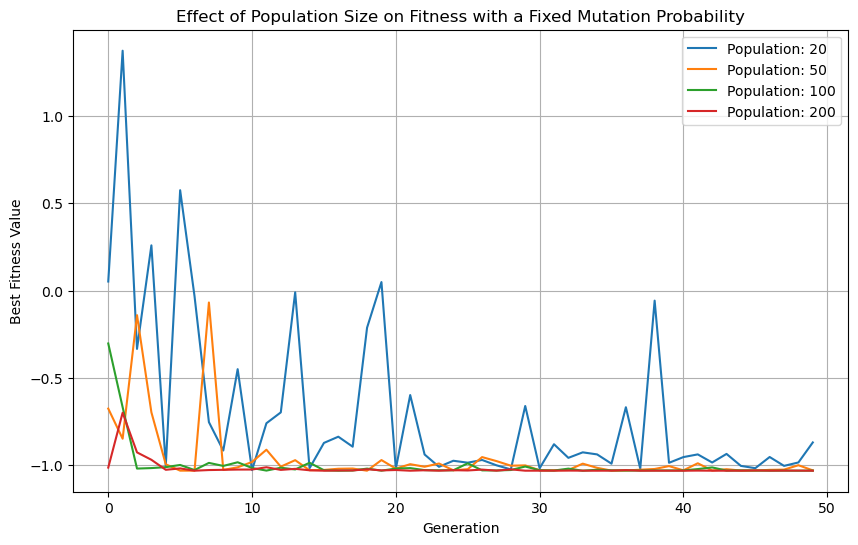

In [31]:
fit_pop_size(mutation_prob=0.15, population_sizes=[20, 50, 100, 200])

Les courbes montrent comment la fitness de la meilleure solution évolue avec les générations pour chaque taille de la population pour une probabilité de mutation donnée.
La courbe bleue qui représente une population de 20 converge très lentement vers la valeur optimale de fitness. Tandis que les courbes rouges et vertes, qui représentent respectivement une population de 100 et de 200, sont celles qui convergent le plus rapidement vers la solution optimale.
Ainsi, on peut déduire qu'en général, une taille de la population accrue permet une exploration plus efficace de l’espace de solutions conduisant une convergence plus rapide vers la solution optimale. En effet, une taille de population plus grande fournit une diversité génétique plus élevée.

<h2 style="padding:16px; color:#FFF; background:#00008B; border-radius: 10px; text-align:center">Predicting rental prices</h2>

## **Introduction**

Dans le cadre de cette étude intitulée ***"Predicting rental prices"***, nous nous penchons sur une question cruciale tant pour les investisseurs que les locataires : comment prévoir au mieux le prix de location d'un logement AirBnB à Londres au travers de multiples informations tant sur l'appartement que sur sa localisation

Notre analyse s'appuie sur un vaste ensemble de données concernant un éventail d'offres trouvées sur le site AirBnB situées à Londres. L'objectif est, par le truchement, de différents modèles, voir quel modèle saura le mieux prédire le prix de location d'un appartement à partir des informations que nous avons dans le dataframe.

L'analyse exploratoire des données, incluant la sélection et le nettoyage des variables, est une étape clé pour préparer les données à l'utilisation de modèles prédictifs. Nous aborderons des techniques statistiques et d'apprentissage machine, telles que la régression linéaire, le modèle Knn ou les arbres de décision, pour construire des modèles capables de prédire la sortie d'une entreprise. Enfin, l'évaluation de la performance de ces modèles, notamment à travers la MSE (**Mean squared error**), permettra de comparer leur efficacité et de sélectionner le plus adapté à notre problématique.


## **Exploration des données**

### ***Nettoyage des données***

On commence par visualiser le jeu de données sur lequel va porter notre analyse. Pour faire cela, on commence par compter le nombre de colonnes ainsi que les types de colonnes que nous avons.

In [3]:
air_bnb = pd.read_csv("airbnb_london_homework.csv")
print(len(air_bnb.columns))

65


Nous allons vérifier que nous n'avons pas de valeurs manquantes dans notre dataframe.

In [4]:
na_counts_dict = air_bnb.isna().sum().to_dict()
print(na_counts_dict)

{'f_property_type': 0, 'f_room_type': 0, 'f_cancellation_policy': 0, 'f_bed_type': 0, 'f_neighbourhood_cleansed': 0, 'usd_price_day': 0, 'n_accommodates': 0, 'n_bathrooms': 0, 'n_review_scores_rating': 0, 'n_number_of_reviews': 0, 'n_guests_included': 0, 'n_reviews_per_month': 0, 'n_extra_people': 0, 'n_minimum_nights': 0, 'n_beds': 0, 'n_days_since': 0, 'd_24hourcheckin': 0, 'd_airconditioning': 0, 'd_breakfast': 0, 'd_buzzerwirelessintercom': 0, 'd_cabletv': 0, 'd_carbonmonoxidedetector': 0, 'd_cats': 0, 'd_dogs': 0, 'd_doorman': 0, 'd_doormanentry': 0, 'd_dryer': 0, 'd_elevatorinbuilding': 0, 'd_essentials': 0, 'd_familykidfriendly': 0, 'd_fireextinguisher': 0, 'd_firstaidkit': 0, 'd_freeparkingonpremises': 0, 'd_freeparkingonstreet': 0, 'd_gym': 0, 'd_hairdryer': 0, 'd_hangers': 0, 'd_heating': 0, 'd_hottub': 0, 'd_indoorfireplace': 0, 'd_internet': 0, 'd_iron': 0, 'd_keypad': 0, 'd_kitchen': 0, 'd_laptopfriendlyworkspace': 0, 'd_lockonbedroomdoor': 0, 'd_lockbox': 0, 'd_otherpets'

Il n'y a pas de valeurs manquantes dans aucune colonne, c'est parfait.

### ***Description des données***

#### **Statistiques descriptives**

In [5]:
colums = ["usd_price_day","n_days_since","n_beds","n_minimum_nights","n_extra_people", "n_accommodates", "n_bathrooms", "n_review_scores_rating","n_number_of_reviews", "n_guests_included", "n_reviews_per_month"]
# Analyse exploratoire : 
for nom in colums :
    tab = air_bnb[nom]
    print(nom)
    print(f'Min : {min(tab.unique())} / Max : {max(tab.unique())} / Moy : {np.mean(tab)} / Médiane : {np.median(tab)} / Ecart-type : {np.sqrt(np.var(tab))} / nombre na : {tab.isna().sum()}')

usd_price_day
Min : 8 / Max : 999 / Moy : 94.8848313518956 / Médiane : 74.0 / Ecart-type : 80.9272272189675 / nombre na : 0
n_days_since
Min : 0 / Max : 2722 / Moy : 418.13259497347326 / Médiane : 327.0 / Ecart-type : 344.64795891292454 / nombre na : 0
n_beds
Min : 0 / Max : 16 / Moy : 1.7088835534213684 / Médiane : 1.0 / Ecart-type : 1.1683758481910234 / nombre na : 0
n_minimum_nights
Min : 1 / Max : 5000 / Moy : 3.3102660419006313 / Médiane : 2.0 / Ecart-type : 29.083436962642462 / nombre na : 0
n_extra_people
Min : 0 / Max : 240 / Moy : 6.665550091004143 / Médiane : 0.0 / Ecart-type : 12.691232512881864 / nombre na : 0
n_accommodates
Min : 1 / Max : 16 / Moy : 3.057177709793595 / Médiane : 2.0 / Ecart-type : 1.888490742844147 / nombre na : 0
n_bathrooms
Min : 0.0 / Max : 8.0 / Moy : 1.2607075088099755 / Médiane : 1.0 / Ecart-type : 0.5270893067343033 / nombre na : 0
n_review_scores_rating
Min : 20 / Max : 100 / Moy : 92.43962746388878 / Médiane : 94.0 / Ecart-type : 8.43827090110824

* Les données explorées montrent une grande variabilité dans plusieurs caractéristiques des annonces Airbnb. Le prix journalier **(usd_price_day)** varie fortement, allant de 8 à 999 USD, avec un prix moyen de 94.88 USD, ce qui montre la diversité des offres. Cependant, la médiane plus basse (74 USD) par rapport à la moyenne suggère que certaines annonces hautement tarifées augmentent cette dernière.

* Les données sur l'ancienneté de publication des annonces **(n_days_since)** présentent également une large amplitude, certaines annonces étant récentes tandis que d'autres sont en ligne depuis plus de sept ans (2722 jours), avec une médiane de 327 jours, ce qui semble indiquer une mixité entre nouvelles et anciennes annonces.

* Concernant les caractéristiques des propriétés, on observe que le nombre moyen de lits (n_beds) est de 1.71, tandis que la capacité d'accueil moyenne **(n_accommodates)** est d'environ 3 personnes. La variabilité reste modérée pour ces deux indicateurs, mais certains logements peuvent accueillir jusqu'à 16 personnes, montrant la présence d'options plus spacieuses. De même, le nombre de salles de bain (n_bathrooms) est en moyenne de 1.26, indiquant que la majorité des logements sont de petite taille ou de type studio, mais il existe des options avec plus de salles de bain.

* Enfin, les données sur les avis montrent que les annonces reçoivent en moyenne un score d'évaluation élevé **(n_review_scores_rating)**, avec une moyenne de 92.4 sur 100, et un écart-type relativement bas, ce qui suggère une satisfaction client globalement positive et homogène pour les logements analysés.

#### **Visualisation graphique**

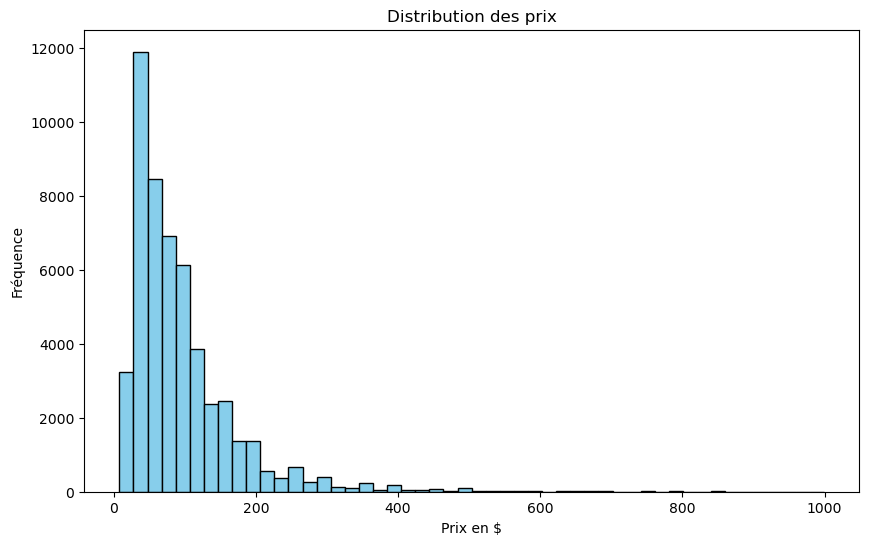

In [6]:
# Histogramme de la colonne 'prix'
plt.figure(figsize=(10, 6))
plt.hist(air_bnb['usd_price_day'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution des prix')
plt.xlabel('Prix en $')
plt.ylabel('Fréquence')
plt.show()


On remarque que la majorité des prix se distribue entre 0 et 200.

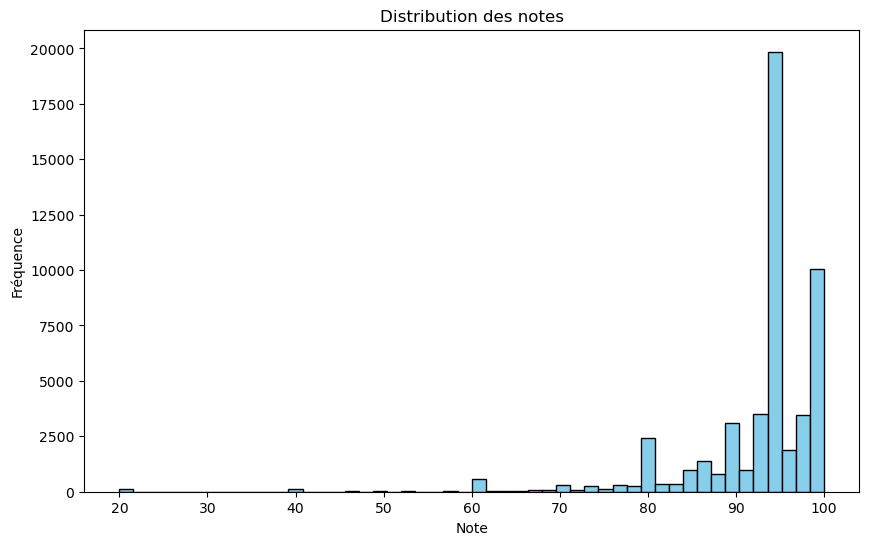

In [7]:
# Histogramme de la colonne 'prix'
plt.figure(figsize=(10, 6))
plt.hist(air_bnb['n_review_scores_rating'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.show()


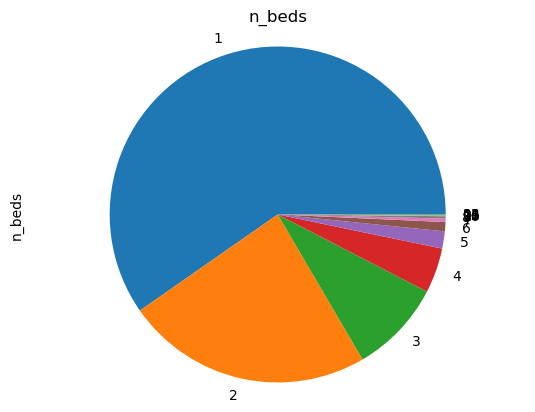

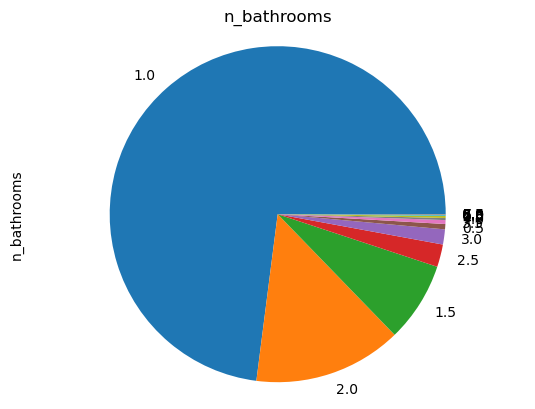

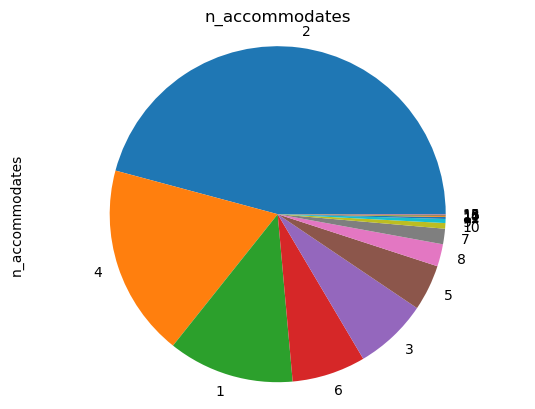

In [8]:
vars = ['n_beds','n_bathrooms','n_accommodates']

for var in vars:
    air_bnb[var].value_counts().plot(kind='pie')
    plt.title(var)
    plt.axis('equal')
    plt.show()

Le diagramme circulaire nous offre une vue d'ensemble de la distribution des modalités au sein des variables qui décrivent au plus le type d'appartements, révélant ainsi la répartition des appartements par taille. Nous constatons que n_accomodates (qui correspond au nombre de gens que l'appartement peut accueillir) comprend un large éventail de modalités, ce qui pourrait compliquer sa modélisation en raison de la granularité élevée des données. 

De plus, l'analyse indique une prédominance des appartements de petite taille (1 lit, 1 salle de bain, pour 2 personnes). Cette prédominance nous questionne davantage sur la répartition des autres variables. C'est ce que nous allons étudier.

In [9]:
#Répartition des données
for nom in colonnes_2:
    tab = air_bnb[nom]
    print(nom)
    for idx in tab.unique():
        count = (air_bnb[nom] == idx).sum()/len(air_bnb)
        print(f'sum indice {idx} = {count}')

NameError: name 'colonnes_2' is not defined

On remarque que certaines de nos variables ont des répartitions très peu équilibrées (99%, 1% par exemple). Nous allons vérifier cela graphiquement en prenant pour exemple 3 variables où c'est le cas.

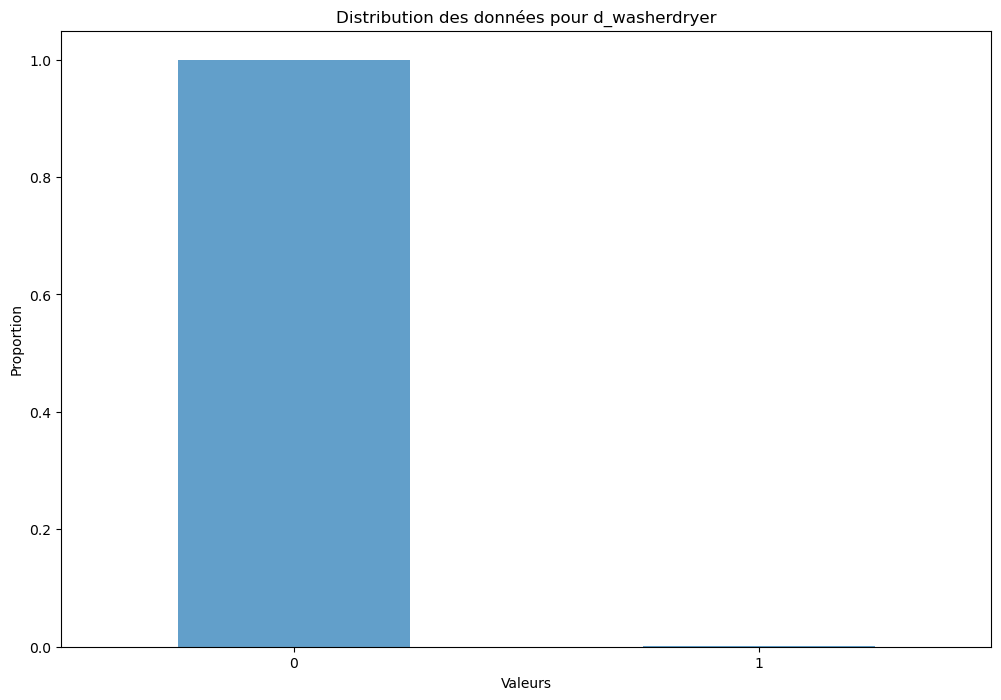

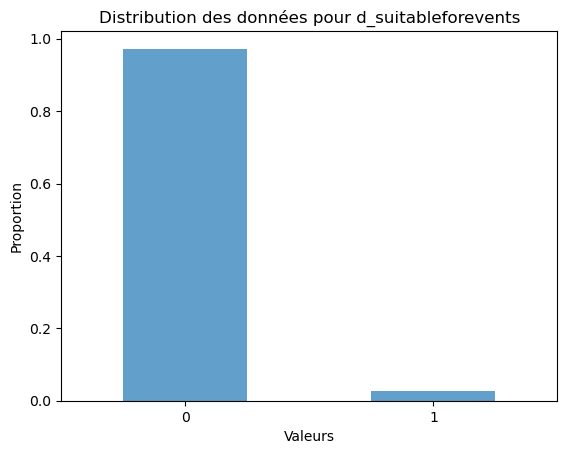

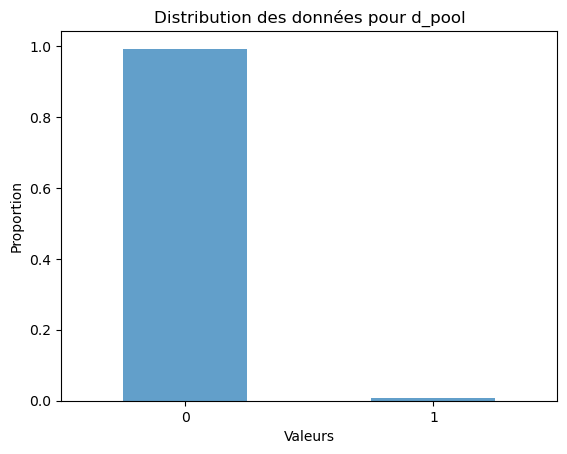

In [10]:
plt.figure(figsize=(12, 8))
colonnes_doute=['d_washerdryer','d_suitableforevents','d_pool']
for nom in colonnes_doute:
    # Calculer la répartition des valeurs 0 et 1
    counts = air_bnb[nom].value_counts(normalize=True)  # Normalisation pour obtenir des proportions
    counts.plot(kind='bar', alpha=0.7, label=nom)

    # Ajouter les étiquettes et le titre
    plt.title(f'Distribution des données pour {nom}')
    plt.xlabel('Valeurs')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    # Afficher le graphique
    plt.show()

Ces variables là, dont la distribution est très hétérogène, sont disqualifiées d'office dans notre prédiction car elles ne contiennent pas suffisamment d'informations discriminantes afin de pouvoir prédire au mieux le prix d'un logement. Nous allons supprimer de notre modèle toutes les variables dont la répartition de Oui/Non est supérieur à 90%/10%. 

In [11]:
columns_to_drop = []
for nom in colonnes_2:
    tab = air_bnb[nom]
    for idx in tab.unique():
        count = (air_bnb[nom] == idx).sum()/len(air_bnb)
        if count > 0.90:
            columns_to_drop.append(nom)
air_bnb_cleaned = air_bnb.drop(columns=columns_to_drop)

NameError: name 'colonnes_2' is not defined

#### **Transformation des variables catégorielles**

In [12]:
colonnes_objet = air_bnb_cleaned.select_dtypes(include=['object'])
print(colonnes_objet.head())

# Compter le nombre de colonnes de type 'object'
nombre_colonnes_objet = colonnes_objet.shape[1]

print("Nombre de colonnes de type 'object' :", nombre_colonnes_objet)

NameError: name 'air_bnb_cleaned' is not defined

On remarque qu'on a 4 colonnes de type object. Nous allons transformer chaque colonne catégorielle en plusieurs colonnes indicatrices, où chaque catégorie devient une colonne binaire (1 si la ligne appartient à la catégorie, 0 sinon). Nous aurons après cela un dataframe où toutes les colonnes ne sont composées que de valeurs numériques.

In [13]:
air_bnb_dumies = pd.get_dummies(air_bnb_cleaned, drop_first=True)
air_bnb_dumies = air_bnb_dumies.astype(int)
print(f'le nombre de variables est maintenant de : {len(air_bnb_dumies.columns)}')

NameError: name 'air_bnb_cleaned' is not defined

#### **Tests statistiques sur la localisation des appartements**

Afin de vérifier que la localisation (colonnes catégorielles qu'on a précedemment transformé en colonnes de variables indicatrices), nous sélectionnons 2 des quarties les plus riches de Londres (Chelsea et Westminster). Nous appliquerons le test du Chi-2 et calculerons le V de Cramer, afin d'évaluer l'intensité de la relation entre les différentes variables catégorielles et le prix du logement. 

In [14]:
from scipy.stats import chi2_contingency
# Sélectionner les variables catégorielles
cat_vars = ['f_neighbourhood_cleansed_Kensington and Chelsea',  'f_neighbourhood_cleansed_Westminster']

# Initialiser les listes pour stocker les résultats
var_names = []
chi2_stats = []
p_values = []
cramer_vs = []

# Parcourir toutes les variables catégorielles
for var in cat_vars:
    # Calculer le tableau de contingence
    contingency_table = pd.crosstab(air_bnb_dumies['usd_price_day'], air_bnb_dumies[var])
    # Calculer la statistique de test du Chi-deux et la p-valeur
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculer le coefficient V de Cramer
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rc = r-((r-1)**2)/(n-1)
    kc = k-((k-1)**2)/(n-1)
    cramer_v = np.sqrt(phi2corr/min(rc-1,kc-1))
    # Ajouter les résultats aux listes correspondantes
    var_names.append(var)
    chi2_stats.append(chi2)
    p_values.append(p)
    cramer_vs.append(cramer_v)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Variable': var_names,
    'Chi2': chi2_stats,
    'P-valeur': p_values,
    'V de Cramer': cramer_vs
})

# Trier le DataFrame par ordre croissant de V de Cramer
results_df.sort_values(by='V de Cramer', inplace=True,ascending=False)

# Afficher le tableau des résultats
print(results_df)

NameError: name 'air_bnb_dumies' is not defined

Les résultats montrent que toutes les p-valeurs sont inférieures à 0.05, confirmant ainsi que ces variables sont statistiquement significatives et pertinentes pour notre analyse. Elles démontrent une association significative avec le prix du logement.

#### **Corrélation et multicolinéarité des variables**

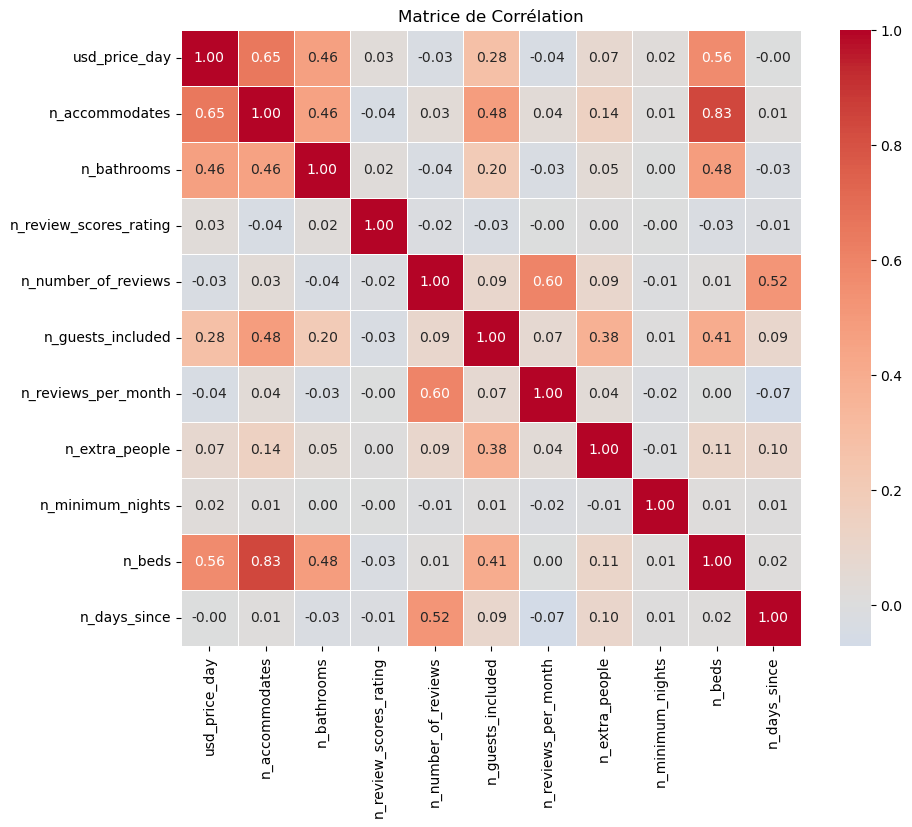

In [194]:
colonnes_2 = [col for col in air_bnb.columns if col not in colums]
matrix = air_bnb.drop(colonnes_2, axis = 1)

correlation_matrix = matrix.corr()

# Affichage de la matrice de corrélation avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=False, linewidths=0.5, fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

Après avoir analysé la matrice de corrélation, nous pouvons identifier beaucoup de "points chauds" avec une forte corrélation, proche de 1, ce qui indique une collinéarité significative entre les variables. Il serait néanmoins fastidieux de juger à la main entre chaque paire de variables vu le nombre très conséquent de variables. Nous allons utiliser la méthode du VIF (Variation inflation factor) afin de juger de la multicolinéarité de nos variables et supprimer les variables dont le VIF suggère qu'elles sont très liées aux autres variables. 

In [187]:
air_bnb_dumies.columns

Index(['usd_price_day', 'n_accommodates', 'n_bathrooms',
       'n_review_scores_rating', 'n_number_of_reviews', 'n_guests_included',
       'n_reviews_per_month', 'n_extra_people', 'n_minimum_nights', 'n_beds',
       'n_days_since', 'd_24hourcheckin', 'd_breakfast',
       'd_buzzerwirelessintercom', 'd_cabletv', 'd_carbonmonoxidedetector',
       'd_dryer', 'd_elevatorinbuilding', 'd_essentials',
       'd_familykidfriendly', 'd_fireextinguisher', 'd_firstaidkit',
       'd_freeparkingonpremises', 'd_hairdryer', 'd_hangers', 'd_internet',
       'd_iron', 'd_laptopfriendlyworkspace', 'd_lockonbedroomdoor',
       'd_safetycard', 'd_shampoo', 'd_smokedetector', 'd_tv', 'd_washer',
       'f_property_type_House', 'f_room_type_Private room',
       'f_room_type_Shared room', 'f_cancellation_policy_moderate',
       'f_cancellation_policy_strict', 'f_neighbourhood_cleansed_Barnet',
       'f_neighbourhood_cleansed_Bexley', 'f_neighbourhood_cleansed_Brent',
       'f_neighbourhood_cleans

In [193]:
X = air_bnb_dumies.drop("usd_price_day", axis = 1)
# Calculer le VIF pour chaque variable
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                          Variable        VIF
0                   n_accommodates  16.814420
1                      n_bathrooms   9.335011
2           n_review_scores_rating  98.583845
3              n_number_of_reviews   3.646638
4                n_guests_included   4.314304
5              n_reviews_per_month   2.781193
6                   n_extra_people   1.526764
7                 n_minimum_nights   1.014685
8                           n_beds  11.074715
9                     n_days_since   5.210502
10                 d_24hourcheckin   1.780215
11                     d_breakfast   1.289198
12        d_buzzerwirelessintercom   1.845735
13                       d_cabletv   1.533221
14        d_carbonmonoxidedetector   2.622701
15                         d_dryer   2.116364
16            d_elevatorinbuilding   1.563514
17                    d_essentials   8.123271
18             d_familykidfriendly   2.809279
19              d_fireextinguisher   1.760616
20                   d_firstaidkit

**Variance Inflation Factor (VIF)**
* C'est un indicateur essentiel en modélisation pour détecter la multicolinéarité entre les variables explicatives. La multicolinéarité se produit lorsque certaines variables indépendantes sont fortement corrélées entre elles, ce qui peut entraîner des problèmes d'estimation dans les modèles de régression, comme l’instabilité des coefficients ou une mauvaise interprétation de leur signification.

* Un VIF élevé (généralement supérieur à 5) indique une forte redondance entre une variable et les autres variables explicatives. Cela peut rendre les coefficients difficiles à interpréter, car une modification dans une variable est en partie expliquée par d’autres. 

**Dans notre analyse, certaines variables présentent des VIF élevés :**

* *n_review_scores_rating* avec un VIF de 102, ce qui indique une multicolinéarité extrêmement élevée.
* *n_accommodates* avec un VIF de 16.99, ce qui est également significatif.
  


In [156]:
list_vif = vif["VIF"].unique()
list_var = vif["Variable"].unique()
print("ces variables ont une multicolinératité faible")
for v,j in zip(list_vif,list_var) : 
    if v <= 1 : 
        print(f"La variable {j} à un vif de {v}")

ces variables ont une multicolinératité faible
La variable n_days_since à un vif de -0.6947924358205992


In [157]:
print("ces variables ont une multicolinératité modérée avec un vif compris entre 1 et 5")
for v,j in zip(list_vif,list_var) : 
    if 1 < v <= 5 :
        print(j)

ces variables ont une multicolinératité modérée avec un vif compris entre 1 et 5
n_number_of_reviews
n_guests_included
n_reviews_per_month
n_extra_people
n_minimum_nights
d_24hourcheckin
d_breakfast
d_buzzerwirelessintercom
d_cabletv
d_carbonmonoxidedetector
d_dryer
d_elevatorinbuilding
d_familykidfriendly
d_fireextinguisher
d_firstaidkit
d_freeparkingonpremises
d_hairdryer
d_internet
d_laptopfriendlyworkspace
d_lockonbedroomdoor
d_safetycard
d_shampoo
d_tv
f_property_type_House
f_room_type_Private room
f_room_type_Shared room
f_cancellation_policy_moderate
f_cancellation_policy_strict
f_neighbourhood_cleansed_Barnet
f_neighbourhood_cleansed_Bexley
f_neighbourhood_cleansed_Brent
f_neighbourhood_cleansed_Bromley
f_neighbourhood_cleansed_City of London
f_neighbourhood_cleansed_Croydon
f_neighbourhood_cleansed_Ealing
f_neighbourhood_cleansed_Enfield
f_neighbourhood_cleansed_Greenwich
f_neighbourhood_cleansed_Haringey
f_neighbourhood_cleansed_Harrow
f_neighbourhood_cleansed_Havering
f_neig

In [158]:
print("ces variables ont une forte multicolinératité avec un vif supèrieur à 5")
X_multicor = []
for v,j in zip(list_vif, list_var) :
    if v > 5 : 
        X_multicor.append(j)
        print(j)

ces variables ont une forte multicolinératité avec un vif supèrieur à 5
n_accommodates
n_bathrooms
n_review_scores_rating
n_beds
d_essentials
d_hangers
d_iron
d_smokedetector
d_washer
f_neighbourhood_cleansed_Camden
f_neighbourhood_cleansed_Hackney
f_neighbourhood_cleansed_Hammersmith and Fulham
f_neighbourhood_cleansed_Islington
f_neighbourhood_cleansed_Kensington and Chelsea
f_neighbourhood_cleansed_Lambeth
f_neighbourhood_cleansed_Southwark
f_neighbourhood_cleansed_Tower Hamlets
f_neighbourhood_cleansed_Wandsworth
f_neighbourhood_cleansed_Westminster


Pour les raisons expliquées précédemment, on choisit d'enlever les variables qui ont une forte multicolinéarité.

In [454]:
y = air_bnb_dumies["usd_price_day"]
X_set= X.drop(X_multicor, axis = 1)
print(f'le nombre de variables de notre base de données est de :{len(X_set.columns)}')

KeyError: "['f_neighbourhood_cleansed_Camden', 'f_neighbourhood_cleansed_Hackney', 'f_neighbourhood_cleansed_Hammersmith and Fulham', 'f_neighbourhood_cleansed_Islington', 'f_neighbourhood_cleansed_Kensington and Chelsea', 'f_neighbourhood_cleansed_Lambeth', 'f_neighbourhood_cleansed_Southwark', 'f_neighbourhood_cleansed_Tower Hamlets', 'f_neighbourhood_cleansed_Wandsworth', 'f_neighbourhood_cleansed_Westminster'] not found in axis"

In [168]:
X_set.columns

Index(['n_number_of_reviews', 'n_guests_included', 'n_reviews_per_month',
       'n_extra_people', 'n_minimum_nights', 'n_days_since', 'd_24hourcheckin',
       'd_breakfast', 'd_buzzerwirelessintercom', 'd_cabletv',
       'd_carbonmonoxidedetector', 'd_dryer', 'd_elevatorinbuilding',
       'd_familykidfriendly', 'd_fireextinguisher', 'd_firstaidkit',
       'd_freeparkingonpremises', 'd_hairdryer', 'd_internet',
       'd_laptopfriendlyworkspace', 'd_lockonbedroomdoor', 'd_safetycard',
       'd_shampoo', 'd_tv', 'f_property_type_House',
       'f_room_type_Private room', 'f_room_type_Shared room',
       'f_cancellation_policy_moderate', 'f_cancellation_policy_strict',
       'f_neighbourhood_cleansed_Barnet', 'f_neighbourhood_cleansed_Bexley',
       'f_neighbourhood_cleansed_Brent', 'f_neighbourhood_cleansed_Bromley',
       'f_neighbourhood_cleansed_City of London',
       'f_neighbourhood_cleansed_Croydon', 'f_neighbourhood_cleansed_Ealing',
       'f_neighbourhood_cleansed_Enf

#### **Réduction de la dimensionnalité**

Etant donné que nous avons encore beaucoup de colonnes, nous avons décidé de grouper les quartiers selon leur composantes socioéconomiques, en effet, un nombre trop élevé de variables dans notre modélisation peut être coûteux tant en temps de calculs qu'en la précision du modèle. 

In [453]:

# Définir les catégories
rich_neighbourhoods = [
    'f_neighbourhood_cleansed_City of London',
    'f_neighbourhood_cleansed_Richmond upon Thames',
    'f_neighbourhood_cleansed_Merton',
]

middle_class_neighbourhoods = [
    'f_neighbourhood_cleansed_Brent',
    'f_neighbourhood_cleansed_Haringey',
    'f_neighbourhood_cleansed_Ealing',
    'f_neighbourhood_cleansed_Bromley',
    'f_neighbourhood_cleansed_Kingston upon Thames',
    'f_neighbourhood_cleansed_Hillingdon',
    'f_neighbourhood_cleansed_Redbridge',
]

poor_neighbourhoods = [
    'f_neighbourhood_cleansed_Croydon',
    'f_neighbourhood_cleansed_Newham',
    'f_neighbourhood_cleansed_Lewisham',
    'f_neighbourhood_cleansed_Harrow',
    'f_neighbourhood_cleansed_Havering',
    'f_neighbourhood_cleansed_Bexley',
    'f_neighbourhood_cleansed_Waltham Forest',
    'f_neighbourhood_cleansed_Sutton',
    'f_neighbourhood_cleansed_Enfield',
    'f_neighbourhood_cleansed_Greenwich',
    'f_neighbourhood_cleansed_Barnet'
    'f_neighbourhood_cleansed_Hounslow',
]

# Initialiser les colonnes Riches, Moyens et Pauvres à 0
X_set['quartier_riche'] = 0
X_set['quartier_moyen'] = 0
X_set['quartier_pauvre'] = 0

# Remplir les colonnes en fonction des quartiers
for index, row in X_set.iterrows():
    if row[rich_neighbourhoods].any():
        X_set.at[index, 'quartier_riche'] = 1
    elif row[middle_class_neighbourhoods].any():
        X_set.at[index, 'quartier_moyen'] = 1
    elif row[poor_neighbourhoods].any():
        X_set.at[index, 'quartier_pauvre'] = 1
# Supprimer les colonnes dummies utilisées pour la classification
X_set.drop(columns=rich_neighbourhoods + middle_class_neighbourhoods + poor_neighbourhoods, inplace=True)



KeyError: "None of [Index(['f_neighbourhood_cleansed_City of London',\n       'f_neighbourhood_cleansed_Richmond upon Thames',\n       'f_neighbourhood_cleansed_Merton'],\n      dtype='object')] are in the [index]"

In [329]:
X_set

,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_days_since,d_24hourcheckin,d_breakfast,d_buzzerwirelessintercom,d_cabletv,d_carbonmonoxidedetector,d_dryer,d_elevatorinbuilding,d_familykidfriendly,d_fireextinguisher,d_firstaidkit,d_freeparkingonpremises,d_hairdryer,d_internet,d_laptopfriendlyworkspace,d_lockonbedroomdoor,d_safetycard,d_shampoo,d_tv,f_property_type_House,f_room_type_Private room,f_room_type_Shared room,f_cancellation_policy_moderate,f_cancellation_policy_strict,f_neighbourhood_cleansed_Hounslow,quartier_riche,quartier_moyen,quartier_pauvre
0,1,1,0,8,7,92,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,15,1,0,0,1,671,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0
2,2,1,0,0,1,242,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0,1,0,0,2,327,1,0,0,1,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0
4,0,1,0,0,1,327,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51641,1,1,0,0,3,177,0,0,1,0,1,1,1,0,1,0,0,1,1,1,1,1,1,0,0,1,0,0,1,0,0,0,0
51642,0,1,0,0,3,327,0,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0
51643,0,1,0,0,10,327,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
51644,0,4,0,35,3,327,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0


## **Modélisation**

* On commence par séparer nos données en ensemble de test et d'entraînement :

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=0.30, random_state=42)


Nous allons standardiser les colonnes numériques

In [435]:
continuous_columns=['n_number_of_reviews','n_guests_included','n_reviews_per_month','n_minimum_nights','n_days_since']
X_train_z = X_train.copy()  # Create a copy to keep dummy variables unchanged
X_test_z = X_test.copy()    # Create a copy to keep dummy variables unchanged

#transformation-standardizing scaling
X_train_z[continuous_columns] = X_train[continuous_columns].apply(lambda x: (x - x.mean()) / x.std())
X_test_z[continuous_columns] = X_test[continuous_columns].apply(lambda x: (x - x.mean()) / x.std())

#### **Random forest régression**

Dans cette partie de notre analyse, nous allons explorer l'utilisation d'un régresseur pour prédire la sortie d'une entreprise : la forêt aléatoire. Ce modèle est particulièrement apprécié pour sa capacité à fournir des résultats explicatifs clairs et à gérer des interactions complexes entre les variables. Pour évaluer et affiner notre modèle de random forest, nous emploierons la technique de validation croisée (5-fold cross validation). Cette méthode robuste nous permettra non seulement d'évaluer la performance de notre modèle de manière fiable, mais aussi de déterminer la profondeur optimale de l'arbre qui minisme la MSE.

In [436]:
from sklearn.ensemble import RandomForestRegressor


In [437]:
# Définition du modèle
rf_model = RandomForestRegressor(random_state=42)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [15, 30, 45],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

In [438]:
# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Effectuer la recherche
grid_search.fit(X_train_z, y_train)

# Meilleurs paramètres et meilleur score
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_  # Inverser car nous avons utilisé 'neg_mean_squared_error'

print("Meilleurs paramètres:", best_params)
print("Meilleur MSE (validation croisée):", best_mse)

Meilleurs paramètres: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 45}
Meilleur MSE (validation croisée): 3544.932420905866


In [439]:
# Évaluation du modèle sur l'ensemble de test
best_rf_model = grid_search.best_estimator_
y_rf_pred = best_rf_model.predict(X_test_z)
final_mse_rf = mean_squared_error(y_test, y_rf_pred)
print("MSE sur l'ensemble de test:", final_mse_rf)

MSE sur l'ensemble de test: 3194.796052239346


In [440]:
from sklearn.feature_selection import SelectFromModel

#### **La régression k-NN**

Dans cette phase de notre étude, nous entreprenons une recherche approfondie pour déterminer le nombre optimal de voisins (n_neighbors) dans notre modèle de régression KNN. Pour ce faire, nous évaluons la performance de modèles variant de 1 à 30 voisins, en utilisant le MSE comme indicateur de performance. La validation croisée stratifiée, appliquée ici, permet de garantir que chaque sous-ensemble de notre échantillon est représentatif de l'ensemble complet, offrant ainsi une évaluation fiable et robuste de la capacité de chaque modèle à généraliser. L'objectif est de sélectionner le nombre de voisins qui minimise le MSE, nous guidant vers le modèle KNN le plus performant pour notre analyse prédictive. Pour optimiser le temps de calcul, ici nous allons utiliser une 3-Fold cross validation et chercher les k 3 par 3.

In [2]:
train_errors = []
test_errors = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation
k_values = range(1, 30,3)
# Loop over each k value
for k in k_values:
    fold_train_errors = []
    fold_test_errors = []
    
    # Loop over each fold
    for train_index, val_index in kf.split(X_train_z):
        X_train_fold, X_val_fold = X_train_z.iloc[train_index], X_train_z.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Initialize and train the KNN model
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_fold, y_train_fold)
        
        # Predict and calculate MSE on training and validation sets for this fold
        y_train_pred_fold = knn.predict(X_train_fold)
        y_val_pred_fold = knn.predict(X_val_fold)
        
        fold_train_errors.append(mean_squared_error(y_train_fold, y_train_pred_fold))
        fold_test_errors.append(mean_squared_error(y_val_fold, y_val_pred_fold))
    
    # Store the average errors for each k value
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))


NameError: name 'X_train_z' is not defined

Text(0, 0.5, 'Mean Error')

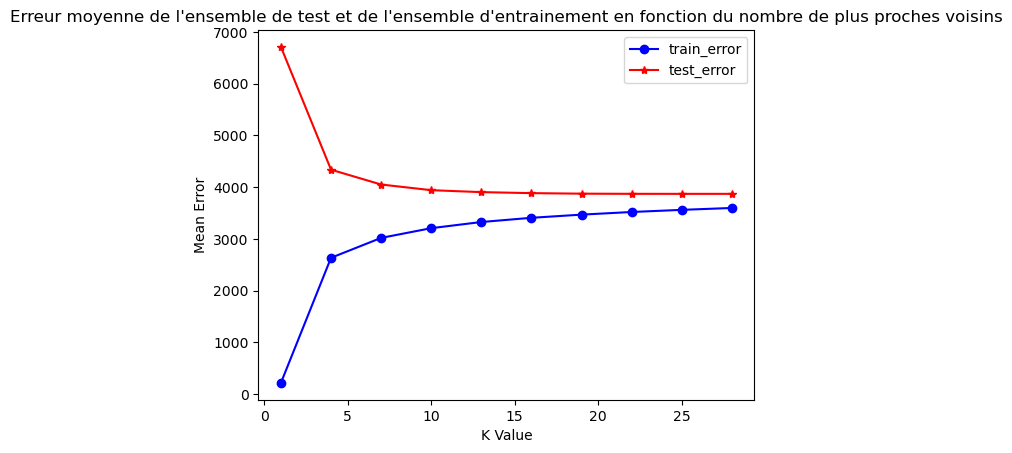

In [442]:
plt.plot(k_values, train_errors,'b-o', label ='train_error', ms=6)
plt.plot(k_values, test_errors, 'r-*', label ='test_error', ms=6)
plt.legend()
plt.title("Erreur moyenne de l'ensemble de test et de l'ensemble d'entrainement en fonction du nombre de plus proches voisins") 
plt.xlabel('K Value')  
plt.ylabel('Mean Error')

In [445]:
train_error = np.array(train_errors)
test_error = np.array(test_errors)

# Trouver le meilleur k
best_k_index = np.argmin(test_error)  # Index du k avec le MSE minimum
best_k = range(1,30,3)[best_k_index]  # Récupérer le meilleur k
mse_knn_final=test_errors[best_k_index]
print(f"Le meilleur k est : {best_k}, Minimum Test MSE: {test_errors[best_k_index]}")


Le meilleur k est : 25, Minimum Test MSE: 3870.690189072262


In [446]:
train_error = []
test_error = []

knn = KNeighborsRegressor(n_neighbors=best_k)  # Utiliser KNeighborsRegressor pour la régression
knn.fit(X_train_z, y_train)
    
# Prédictions sur l'ensemble d'entraînement et de test
y_train_pred = knn.predict(X_train_z)
y_test_pred = knn.predict(X_test_z)
    
# Calcul des erreurs
train_error.append(mean_squared_error(y_train, y_train_pred))
test_error.append(mean_squared_error(y_test, y_test_pred))

#### **Régression linéaire**

Dans cette phase de notre étude, nous entreprenons une recherche approfondie pour déterminer le nombre optimal de voisins (n_neighbors) dans notre modèle de régression KNN. Pour ce faire, nous évaluons la performance de modèles variant de 1 à 30 voisins, en utilisant le MSE comme indicateur de performance. La validation croisée stratifiée, appliquée ici, permet de garantir que chaque sous-ensemble de notre échantillon est représentatif de l'ensemble complet, offrant ainsi une évaluation fiable et robuste de la capacité de chaque modèle à généraliser. L'objectif est de sélectionner le nombre de voisins qui minimise le MSE, nous guidant vers le modèle KNN le plus performant pour notre analyse prédictive. Pour optimiser le temps de calcul, ici nous allons utiliser une 3-Fold cross validation et chercher les k 3 par 3.

In [463]:
# forward selection
def forward_regression(X_train, y_train,
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X_train_z.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_z[included+[new_column]]))).fit(disp=False)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True

        if not changed:
            break

    return included


In [464]:
C_forward = forward_regression(X_train_z, y_train)

In [457]:
X_forward = X_train_z[C_forward]
X_forward = X_forward.assign(Intercept=1)

In [458]:
print(len(C_forward))
def regression_lineair(X, y):
    X = X.assign()
    model = sm.OLS(y,X)
    result=model.fit()
    return(result)

25


In [459]:
print(regression_lineair(X_forward,y_train).summary())

                            OLS Regression Results                            
Dep. Variable:          usd_price_day   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     877.8
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:27:16   Log-Likelihood:            -2.0195e+05
No. Observations:               36152   AIC:                         4.040e+05
Df Residuals:                   36126   BIC:                         4.042e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
d_tv  

Notre modèle ajusté a atteint une signification statistique globale avec un R² conséquent, et avec tous les coefficients des variables se révélant être significatifs. Cela indique que chaque variable sélectionnée joue un rôle explicatif significatif dans la modélisation du phénomène étudié.

In [399]:
# backward selection
def backward_regression(X_train_z, y_train,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X_train_z.columns)
    while True:
        changed=False
        model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_z[included]))).fit(disp=False)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        if not changed:
            break
    return included

In [400]:
C_backward = backward_regression(X_train_z, y_train)

In [465]:
print(len(C_backward))
X_backward= X_train_z[C_backward]
X_backward = X_backward.assign(Intercept=1)

26


In [466]:
X_backward_test=X_test_z[X_test_z.columns.intersection(X_backward.columns)]
X_backward_test = X_backward_test.assign(Intercept=1)

In [467]:
X_forward_test=X_test_z[X_test_z.columns.intersection(X_forward.columns)]
X_forward_test= X_forward_test.assign(Intercept=1)


In [468]:
print(regression_lineair(X_backward,y_train).summary())

                            OLS Regression Results                            
Dep. Variable:          usd_price_day   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     844.3
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:28:06   Log-Likelihood:            -2.0195e+05
No. Observations:               36152   AIC:                         4.040e+05
Df Residuals:                   36125   BIC:                         4.042e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
n_gues

In [469]:
result_B=regression_lineair(X_backward,y_train)
result_F=regression_lineair(X_forward,y_train)

In [470]:
y_train_pred_backward = result_B.predict(X_backward_test)
y_train_pred_forward = result_F.predict(X_forward_test)
len(y_train_pred_backward)
# Calculate MSE for each model
mse_backward = mean_squared_error(y_test, y_train_pred_backward)
mse_forward = mean_squared_error(y_test, y_train_pred_forward)

# Display the results
print(f"MSE for backward model: {mse_backward}")
print(f"MSE for forward model: {mse_forward}")

MSE for backward model: 3813.199485127562
MSE for forward model: 13748.223048260663


La MSE du modèle backward est plus faible, on garde donc le modèle backward.

## **Amélioration de la performance des modèles**

### ***RFR***

#### *Régression Lasso*

Nous entamons un processus d'entraînement de modèles de régression où Lasso est utilisé pour la sélection des caractéristiques, suivi de l'entraînement d'un modèle de Random Forest sur ces caractéristiques sélectionnées. L'approche vise à améliorer la précision du modèle tout en réduisant la complexité en éliminant les caractéristiques non pertinentes.

In [471]:
alphas = 10**np.linspace(10, -2, 100) * 0.5
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_z, y_train)
    coefs.append(lasso.coef_)

# Using LassoCV to find the best alpha
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000)
lassocv.fit(X_train_z, y_train)

# Fitting Lasso with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_z, y_train)

# Selecting important features
selected_features = np.where(lasso.coef_ != 0)[0]

# Step 2: Train Random Forest Model using selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]


rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train_selected, y_train)

# Step 3: Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test_selected)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Meilleur alpha pour Lasso:", lassocv.alpha_)
print("MSE Random Forest avec sélection des caractéristiques (Lasso):", mse_rf)

Meilleur alpha pour Lasso: 0.07464096749140667
MSE Random Forest avec sélection des caractéristiques (Lasso): 3200.0450538646696


In [427]:
print(f'notre mse précédentes était de :{final_mse_rf}')
print(f'avec le lasso elle est maintenant de :{mse_rf}')

notre mse précédentes était de :3194.796052239346
avec le lasso elle est maintenant de :3178.5214647652892


Nous avons réussi à baisser notre MSE en utilisant la méthode Lasso dans la sélection de nos variables, notre modèle a en effet un MSE plus faible.

### ***Régression k-NN***

#### *Lasso*

In [432]:
knn_model = KNeighborsRegressor(n_neighbors=25) 
knn_model.fit(X_train_selected, y_train)

y_pred_knn = knn_model.predict(X_test_selected)
mse_knn = mean_squared_error(y_test, y_pred_knn)

# Afficher les résultats
print("Meilleur alpha pour Lasso:", lassocv.alpha_)
print("MSE KNN avec sélection des caractéristiques (Lasso):", mse_knn)

Meilleur alpha pour Lasso: 0.07464096749140667
MSE KNN avec sélection des caractéristiques (Lasso): 4830.264200748677


In [431]:
print(f'notre mse précédente était de :{mse_knn_final}')
print(f'avec le lasso elle est maintenant de :{mse_knn}')

notre mse précédente était de :3870.690189072262
avec le lasso elle est maintenant de :4830.264200748677


#### **Implémantation d'un ridge, lasso et algorithme génétique sur notre regression linéaire**

In [352]:
coefs = map(lambda a: linear_model.Ridge(a).fit(X, y).coef_.flatten(), alphas)
coefs = np.array(list(coefs))


# Ridge regression with cross validation


best_model = linear_model.RidgeCV(alphas)
b = best_model.fit(X, y)


NameError: name 'linear_model' is not defined

In [342]:

# Parameter grid for alpha values
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Ridge Tuning
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)
print("Best alpha for Ridge:", ridge_grid.best_params_)
print("Best Ridge R^2 Score:", ridge_grid.best_score_)

# Lasso Tuning
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)
print("Best alpha for Lasso:", lasso_grid.best_params_)
print("Best Lasso R^2 Score:", lasso_grid.best_score_)


Best alpha for Ridge: {'alpha': 100}
Best Ridge R^2 Score: 0.39372656275606244
Best alpha for Lasso: {'alpha': 0.1}
Best Lasso R^2 Score: 0.3937564196940817


* On gardera la spécification du lasso, car pour un alpha de 0.1

In [343]:
# Lasso Regression
lasso_model = Lasso(alpha=0.1)  # Starting with alpha=0.1, can be tuned
lasso_scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2')
lasso_model.fit(X_train_scaled, y_train)
print("Lasso Regression R^2 Score (Cross-Validation):", lasso_scores.mean())
print("Lasso Coefficients:", lasso_model.coef_)


best_alpha = 0.1  # Remplacez par la meilleure valeur d'alpha trouvée
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_lasso_pred = lasso_model.predict(X_test_scaled)


Lasso Regression R^2 Score (Cross-Validation): 0.3937564196940817
Lasso Coefficients: [  8.47985928 -34.80972982   6.07124626  12.06952939  -7.83796083
   6.31406302   5.66147633   5.91215952  -3.89912534   5.63647305
  -4.81838711   4.07949306  -3.95084935   3.53681876  -3.82063578
  -3.40881845  -3.35595957  -2.94891725   3.34357245  -2.82070221
  -1.92135949  -2.52739444  -2.4852694   -2.26894134  -2.25677873
  -2.19594353  -2.08650042  -2.19100689  -1.93262454  -1.65674387
   1.68866224  -1.68204122   1.86545537  -1.74670214  -1.541087
  -1.94678242   1.35460049  -1.58859152   1.35753149  -1.27661193
   1.24402662  -1.19811237  -1.13404113  -1.28134991   1.11599134
   1.12912445  -0.95686876   0.958042    -0.96976138  -0.83102969
  -0.81015132   0.72525413]


In [361]:
def getFitness(individual, X, y):
    # Choisir les colonnes avec index=0
    cols = [index for index in range(len(individual)) if individual[index] == 0]

    # Obtenir le sous-ensemble de caractéristiques
    if isinstance(X, pd.DataFrame):
        X_parsed = X.drop(X.columns[cols], axis=1)  # Si X est un DataFrame
        X_parsed = sm.add_constant(X_parsed)

    else:
        # Si X est un tableau numpy, sélectionnez les colonnes à garder
        mask = np.ones(X.shape[1], dtype=bool)
        mask[cols] = False
        X_parsed = X[:, mask]  # Conserver les colonnes non supprimées

    # Appliquer l'algorithme de régression
    model = sm.OLS(y, X_parsed)
    regr = model.fit()

    last_bic = regr.bic

    return (-regr.bic,)  #

In [362]:
def geneticAlgorithm(X, y, n_population, n_generation):
    """
    Deap global variables
    Initialize variables to use eaSimple
    """
    # create individual
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    #creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    #creator.create("Individual", list, fitness=creator.FitnessMin)

    # create toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat,
                     creator.Individual, toolbox.attr_bool, len(X.columns))
    toolbox.register("population", tools.initRepeat, list,
                     toolbox.individual)
    toolbox.register("evaluate", getFitness, X=X, y=y)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # initialize parameters
    pop = toolbox.population(n=n_population)
    hof = tools.HallOfFame(n_population * n_generation)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.1,
                                   ngen=n_generation, stats=stats, halloffame=hof,
                                   verbose=True)

    # return hall of fame
    return hof, log

In [359]:
def bestIndividual(hof, X, y):
    """
    Get the best individual
    """
    maxAccuracy = None
    for individual in hof:
        if maxAccuracy is None or (individual.fitness.values[0] > maxAccuracy):
            maxAccuracy = individual.fitness.values
            _individual = individual

    _individualHeader = [list(X)[i] for i in range(
        len(_individual)) if _individual[i] == 1]
    return _individual.fitness.values, _individual, _individualHeader

In [363]:
individual0 = [1 for i in range(len(X_forward.columns))]
np.sum(individual0)
print("BIC with all features: \t" + 
      str(getFitness(individual0, X_forward, y_train)) + "\n")

n_pop = 50
n_gen = 50
# apply genetic algorithm
hof, log = geneticAlgorithm(X_forward, y_train, n_pop, n_gen)



# select the best individual
accuracy, individual, header = bestIndividual(hof, X, y)

print(f"Dernière valeur de BIC : {last_bic}")


print('Number of Features in Subset: \t' + str(individual.count(1)))
print('Individual: \t\t' + str(individual))
print('Feature Subset\t: ' + str(header))


BIC with all features: 	(-404182.4348871489,)

gen	nevals	avg    	min    	max    
0  	50    	-411118	-419330	-404679
1  	40    	-407340	-414742	-405021
2  	42    	-405719	-407274	-404729
3  	40    	-405321	-406271	-404729
4  	36    	-405410	-412852	-404615
5  	39    	-405039	-406815	-404601
6  	40    	-404871	-405209	-404576
7  	34    	-404755	-405602	-404392
8  	34    	-404608	-405104	-404392
9  	45    	-404549	-405393	-404300
10 	39    	-404485	-405540	-404291
11 	41    	-404565	-412021	-404284
12 	38    	-404367	-405320	-404284
13 	34    	-404449	-411374	-404284
14 	42    	-404357	-405995	-404284
15 	44    	-404327	-405421	-404284
16 	37    	-404321	-405563	-404284
17 	35    	-404372	-406615	-404225
18 	42    	-404646	-412726	-404225
19 	42    	-404286	-404747	-404194
20 	42    	-404323	-405456	-404194
21 	41    	-404918	-414946	-404194
22 	44    	-404516	-411561	-404194
23 	35    	-404281	-405812	-404194
24 	42    	-404427	-411651	-404194
25 	39    	-404461	-412301	-404194
26 	46  

NameError: name 'last_bic' is not defined

* Au vu des résulats en term de MSE et BIC réalisé sur les différents model, on garderas les model d'origine sans changement effectuer par le ridge, lasso et AG pour faire les prévisions

## **prévisions**

In [422]:
model_ols = sm.OLS(y_train, X_train_z).fit()

knn_model = KNeighborsRegressor(n_neighbors=best_k)  # Utilisez KNeighborsRegressor pour la régression
knn_model.fit(X_train_selected, y_train)

KNeighborsRegressor(n_neighbors=25)

In [424]:
# Effectuer les prédictions pour chaque modèle
y_pred_knn = knn_model.predict(X_test_selected)  # KNN Regression
y_pred_OLS = model_ols.predict(X_test_z) # OLS regression
y_pred_rf = best_rf_model.predict(X_test_z)  # Random Forest Regression

# Calculer le MSE pour chaque modèle (facultatif, pour afficher les performances)
mse_knn = mean_squared_error(y_test, y_pred_knn)
mse_OLS = mean_squared_error(y_test, y_pred_OLS)
mse_rf = mean_squared_error(y_test, y_pred_rf)


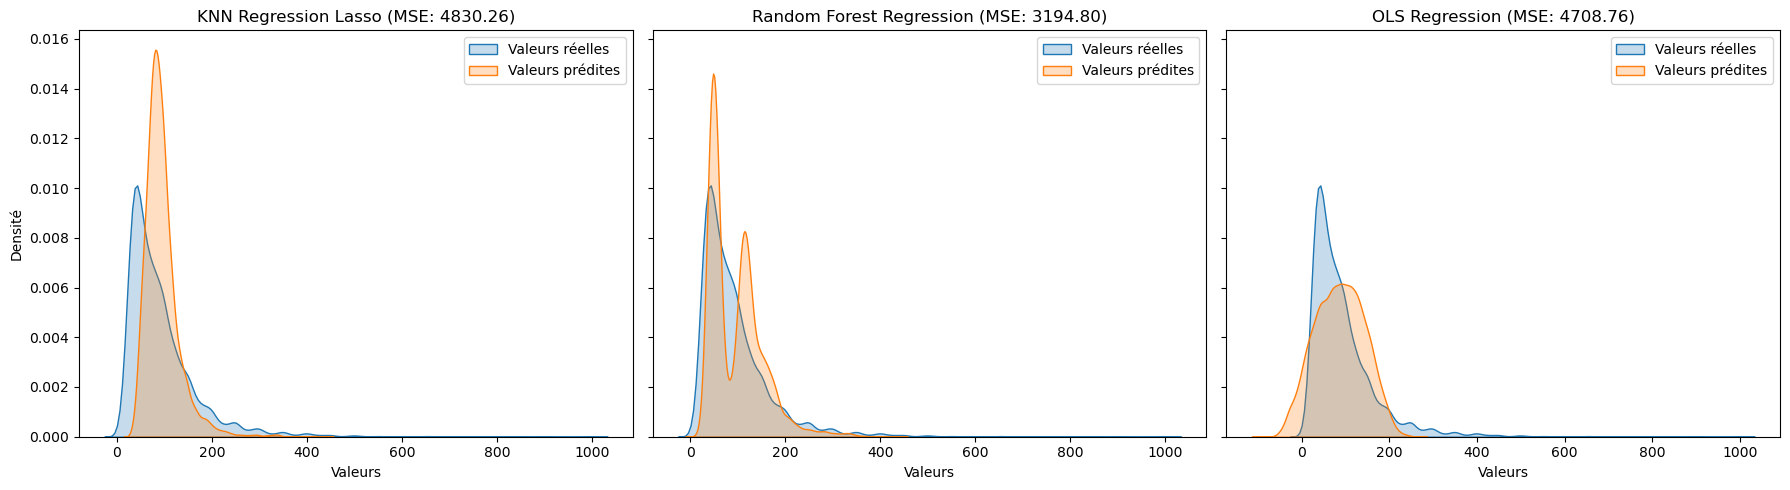

In [425]:
# Créer les sous-graphiques pour chaque modèle
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Paramètres pour chaque modèle
models = [
    ('KNN Regression Lasso', y_pred_knn, mse_knn),
    ('Random Forest Regression', y_pred_rf, mse_rf),
    ('OLS Regression', y_pred_OLS, mse_OLS)
]

# Tracer les courbes de densité
for i, (title, y_pred, mse) in enumerate(models):
    sns.kdeplot(y_test, fill=True, label='Valeurs réelles', ax=axes[i])
    sns.kdeplot(y_pred, fill=True, label='Valeurs prédites', ax=axes[i])
    
    axes[i].set_xlabel('Valeurs')
    axes[i].set_ylabel('Densité' if i == 0 else "")
    axes[i].set_title(f"{title} (MSE: {mse:.2f})")
    axes[i].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()
